In [1]:
import torch
import numpy as np
import torch.nn as nn
import os
import sys
import torch.nn.functional as F
import os.path as osp

from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

from model import PointNetWithSPH
from modelnet_dataset import ModelNet40Generator



## Model params

In [2]:
# Model params
out_channels = (64, 256, 1024)
kernel_radius = 1.0*np.array([0.4*0.25, 0.4*0.5, 0.4*1., 1.])
strides = [0]*3
nr = 2
l_max = 3
normalize_patches = False
patch_size = 64
pool_ratio = 4
nlatent = 1024

# Data params
data_dir = '/mnt/disk1/datasets/modelnet40_ply_hdf5_2048'
train_file = 'train_files.txt'
test_file = 'test_files.txt'

# Training params
n_epoch = 250
lr = 1e-3

## Define and train

In [ ]:

# Model
model = PointNetWithSPH(out_channels, kernel_radius, strides, l_max, nr, patch_size,
                        pool_ratio, nlatent)
model = model.cuda().float()
# Dataset and loader
train_dataset = ModelNet40Generator('train', data_dir, train_file)
test_dataset = ModelNet40Generator('test', data_dir, test_file)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16, drop_last=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cat_loss = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20, threshold=1e-3)

train_loss_epoch, test_loss_epoch, train_acc_epoch, test_acc_epoch = [], [], [], []

for n_e in tqdm(range(n_epoch)):
    model.train()
    train_loss_iter, test_loss_iter, test_acc_iter, train_acc_iter = [], [], [], []
    for X, Y in train_loader:
        X = X.cuda().float()
        Y = Y.cuda()
        optimizer.zero_grad()
        prediction = model(X.float())
        cur_loss = cat_loss(prediction, torch.argmax(Y, axis=1))
#         l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
#         cur_loss += 1e-4*l2_norm
        cur_loss.backward()
        optimizer.step()
        train_loss_iter.append(cur_loss.item())
        train_acc = torch.sum(torch.exp(prediction).argmax(axis=1) == Y.argmax(axis=1))/int(prediction.shape[0])
        train_acc_iter.append(train_acc.item())
        
    for X, Y in test_loader:
        X = X.cuda().float()
        Y = Y.cuda()
        model.eval()
        prediction = model(X.float())
        cur_loss = cat_loss(prediction, torch.argmax(Y, axis=1))
        test_loss_iter.append(cur_loss.item())
        test_acc = torch.sum(torch.exp(prediction).argmax(axis=1) == Y.argmax(axis=1))/int(prediction.shape[0])
        test_acc_iter.append(test_acc.item())

    scheduler.step(torch.cuda.FloatTensor(test_acc_iter[-1]))
    train_loss_epoch.append(np.mean(train_loss_iter))
    test_loss_epoch.append(np.mean(test_loss_iter))

    train_acc_epoch.append(np.mean(train_acc_iter ))
    test_acc_epoch.append(np.mean(test_acc_iter))
    
    
#     print("Train loss : %f" %train_loss_epoch[-1])
    print("Train Accuracy : %f" %train_acc_epoch[-1])
#     print("Test loss : %f" %test_loss_epoch[-1])
    print("Test Accuracy : %f" %test_acc_epoch[-1])

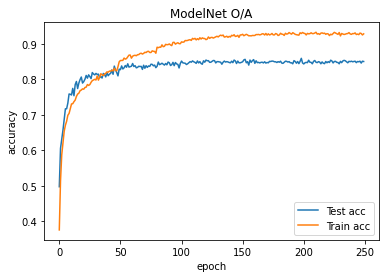

In [7]:
import matplotlib.pyplot as plt

plt.title("ModelNet O/A")
plt.plot(np.arange(len(test_acc_epoch)), test_acc_epoch, label='Test acc')
plt.plot(np.arange(len(train_acc_epoch)), train_acc_epoch, label='Train acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()


### Unit testing for comparing Patches, kernel bw TF and Pytorch

## Warning : Don't run unless you want to test both the implementation ;)

In [ ]:
import tensorflow as tf

def costly_cdist_torch(points, roots):
    # This exists because torch.cdist is inconsistent
    r0 = torch.multiply(roots, roots)
    r0 = torch.sum(r0, dim=2, keepdim=True)
    r1 = torch.multiply(points, points)
    r1 = torch.sum(r1, dim=2, keepdim=True)
    r1 = r1.transpose(2, 1)

    sq_distance_mat = r0 - 2.*torch.matmul(roots, points.transpose(2, 1)) + r1
    return sq_distance_mat
    
    
def build_patch_tf(x):

    assert isinstance(x, list)
    points_pl = x[0]
    roots = x[1]

    batch_size = points_pl.get_shape()[0]
    num_of_points = points_pl.get_shape()[1]
    num_of_roots = roots.get_shape()[1]
    assert(num_of_points >= 64)
    num_samples = 64

    # compute distance mat

    r0 = tf.multiply(roots, roots)
    r0 = tf.reduce_sum(r0, axis=2, keepdims=True)

    r1 = tf.multiply(points_pl, points_pl)
    r1 = tf.reduce_sum(r1, axis=2, keepdims=True)
    r1 = tf.transpose(r1, [0, 2, 1])

    sq_distance_mat = r0 - 2.*tf.matmul(roots, tf.transpose(points_pl, [0, 2, 1])) + r1


    """
    r = tf.multiply(points_pl, points_pl)
    r = tf.reduce_sum(r, 2)
    r = tf.expand_dims(r, dim=2)
    sq_distance_mat = r - 2. * tf.matmul(points_pl, tf.transpose(points_pl, [0, 2, 1])) + tf.transpose(
        r, [0, 2, 1])
    """
    # compute patches
    assert(num_samples <= num_of_points)

    sq_patches_dist, patches_idx = tf.nn.top_k(-sq_distance_mat, k=num_samples)
    sq_patches_dist = -sq_patches_dist


    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    batch_idx = tf.tile(batch_idx, (1, num_of_roots, num_samples))
    b_patches_idx = tf.stack([batch_idx, patches_idx], -1)

    patches = tf.gather_nd(points_pl, b_patches_idx)


    patches = tf.subtract(patches, tf.expand_dims(roots, axis=2))


    return [patches, patches_idx, sq_patches_dist, sq_distance_mat]

def compute_patches_torch(points, roots):
    """
    Compute point-wise distance matrix, apply KDTree to get 64 neighbour for each
    """
    num_of_points = points.shape[1]
    assert(num_of_points >= 64)

#     dist_mat = torch.cdist(points, roots)
    dist_mat = costly_cdist_torch(points, roots)
    sq_patches_dist, patches_idx = torch.topk(-dist_mat, 64*1, dim=-1, )
    sq_patches_dist = -sq_patches_dist
    patches = points[torch.arange(points.shape[0]).unsqueeze(1).unsqueeze(2), patches_idx]

    patches = torch.subtract(patches, roots.unsqueeze(2))
    return patches, patches_idx, sq_patches_dist, dist_mat



In [ ]:
points = np.random.uniform(-1, 1., (10, 1000, 3))
points_torch = torch.from_numpy(points).float()
points_tf = tf.constant(points, dtype=tf.float64)

patches_pyt, patches_idx_pyt, sq_patches_dist_pyt, sq_distance_mat_pyt = compute_patches_torch(points_torch, points_torch)
patches_tf, patches_idx_tf, sq_patches_dist_tf, sq_distance_mat_tf = build_patch_tf([points_tf, points_tf])

np.allclose(sq_patches_dist_pyt.numpy(), sq_patches_dist_tf.numpy(), atol=1e-6)
# np.nonzero(patches_tf.numpy()-patches_pyt.numpy())[0].shape


### Unit testing for comparing kernel bw pytorch and TF

In [ ]:

from tf_spherical_harmonics import normalized_sh
from layers import SPHConvNet


def tf_gaussian(x, sigma):

    # sigma = 3*sigma
    x2 = tf.multiply(x, x)
    return tf.exp(-x2 / (2. * (sigma ** 2)))

def tf_sh_kernel_(X, sq_dist, nr, l_max, rad, normalize_patch=False,
                  radial_first=True,
                  dtype=tf.float64):
    # Y = unnormalized_sh(X, l_max, dtype=dtype)
    Y = normalized_sh(X, l_max, dtype=dtype, eps=0.0001)
    sh = Y

    dist = tf.sqrt(tf.maximum(sq_dist, 0.0001))

    dist = tf.expand_dims(dist, axis=-1)
    r = tf.cast(tf.reshape(tf.linspace(start=0., stop=rad, num=nr), shape=(1, 1, 1, nr)), dtype)
    r = tf.subtract(dist, r)
    sigma = (rad/(nr - 1))
    radial_weights = tf_gaussian(r, sigma)
    if radial_first:
        Y = tf.expand_dims(Y, axis=-2)
        radial_weights = tf.expand_dims(radial_weights, axis=-1)
    else:
        Y = tf.expand_dims(Y, axis=-1)
        radial_weights = tf.expand_dims(radial_weights, axis=-2)

    y = tf.multiply(Y, radial_weights)

    # y = tf.expand_dims(Y, axis=-1)
    # y = tf.tile(y, multiples=(1, 1, 1, 1, 3))


    y_w = tf.expand_dims(tf.expand_dims(y[:, :, :, 0, 0], axis=-1), axis=-1)
    y_w = tf.reduce_sum(y_w, axis=2, keepdims=True)
    y = tf.divide(y, y_w + 0.000001)
    return y, dist



conv1 = SPHConvNet(3, 64,l_max, nr, patch_size, kernel_radius[0], 
                   strides=strides[0], tree_spacing=0, keep_num_points=True,
                   max_pool = 0, l2_regularizer=1.0e-3, with_relu=True,  
                   normalize_patch=False)

tf_kernel = tf_sh_kernel_(patches_tf, sq_patches_dist_tf, nr, l_max, kernel_radius[0], normalize_patch=False,
                          radial_first=False, dtype=tf.float64)
torch_kernel = conv1.compute_conv_kernel(patches_pyt, sq_patches_dist_pyt)

np.allclose(tf_kernel[0].numpy(), torch_kernel.detach().cpu().numpy())
